In [5]:
import pyspark 
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, translate
from IPython.core.display import display, HTML

In [6]:

spark= SparkSession.builder.appName('MLFlowRegression').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/31 11:28:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [3]:
# read the data to create spark data frame 
airBnBData = spark.read.csv('/Users/badr/Desktop/python/MLpySpark/ml-100k/listings.csv',header='true', inferSchema='true', multiLine='true',escape='"' )

In [4]:
# display all column that has integer value 
null_columns = [column for column in airBnBData.columns if airBnBData.where(col(column).isNull()).count() > 0]

In [45]:

column_data_types = airBnBData.dtypes

# Count the occurrences of each data type
data_type_counts = {}
for _, data_type in column_data_types:
    data_type_counts[data_type] = data_type_counts.get(data_type, 0) + 1

# Create a DataFrame from the data type counts dictionary
data_type_count_df = spark.createDataFrame(data_type_counts.items(), ["Data Type", "Count"])

# Show the DataFrame with data type counts
data_type_count_df.show()

+---------+-----+
|Data Type|Count|
+---------+-----+
|      int|   24|
|   string|   58|
|   bigint|    1|
|     date|    5|
|   double|    4|
+---------+-----+



In [53]:
intCount = data_type_count_df.filter(data_type_count_df['Data Type'] =='int').select('Count').first()[0]
stringCount = data_type_count_df.filter(data_type_count_df['Data Type'] =='string').select('Count').first()[0]
bigIntCount = data_type_count_df.filter(data_type_count_df['Data Type'] =='bigint').select('Count').first()[0]
doubleCount = data_type_count_df.filter(data_type_count_df['Data Type'] =='double').select('Count').first()[0]
print(intCount[0])

24


In [1]:
from reportlab.lib.pagesizes import letter, landscape , A4
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from content  import title , introduction ,objectives 
from config import headerTitle, blueFont , contentText , tableStyle

import matplotlib.pyplot as plt
pdf_filename = 'report.pdf'
doc = SimpleDocTemplate(pdf_filename, pagesize= A4)

# Sample content
story = []

# Add title 
p = Paragraph(title, headerTitle)
story.append(p)
story.append(Spacer(1, 12))
# add introduction 
p = Paragraph(introduction, contentText)
story.append(p)
story.append(Spacer(1, 12))
for text, style in objectives:
    story.append(Paragraph(text, style))
story.append(Spacer(1, 12))

# add table for content 
# Convert DataFrame to a list of lists for the table
table_data = [list(data_type_count_df.columns)] + data_type_count_df.values.tolist()

# Create a Table object from the DataFrame
table = Table(table_data, colWidths=[100, 50, 100])

# Apply table style (optional)
table.setStyle(tableStyle)

# Add the table to the story
story.append(table)

doc.build(story)

In [5]:
# get the columns that is integer type 
from pyspark.sql.types import IntegerType , DoubleType
integer_type = [col.name for col in airBnBData.schema.fields if col.dataType == IntegerType()]
display(integer_type)

['id',
 'host_id',
 'host_listings_count',
 'host_total_listings_count',
 'accommodates',
 'bedrooms',
 'beds',
 'square_feet',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'calculated_host_listings_count']

In [6]:
# convert all integer values to double 
from pyspark.sql.functions import cast, translate
airBnBData_v1 = airBnBData

# airBnBData1 = airBnBData.select(*[col(col_name).cast('double').alias(col_name) for col_name in integer_type])

for col_name in integer_type:
   airBnBData_v1 = airBnBData_v1.withColumn(col_name, col(col_name).cast("double")) 

In [7]:
# create correlation between all column and the target column price and show result in dataframe 

# first get list of all column names 
col_names = [columnName.name for columnName in airBnBData_v1.schema.fields if columnName.dataType == DoubleType()]
display(col_names)
# second see if the target column has zero or null values 
airBnBData_v1 = airBnBData_v1.filter((col('bedrooms') > 0 ) & (col('minimum_nights') <= 365) & (col('price').isNotNull()))
print(airBnBData_v1.count())

['id',
 'host_id',
 'host_listings_count',
 'host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'square_feet',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'calculated_host_listings_count',
 'reviews_per_month']

3438


In [8]:
from pyspark.sql import functions as F
room_Type = airBnBData_v1.groupBy('room_type') \
    .agg(F.count('*').alias('count')) \
    .orderBy(F.desc('count'))

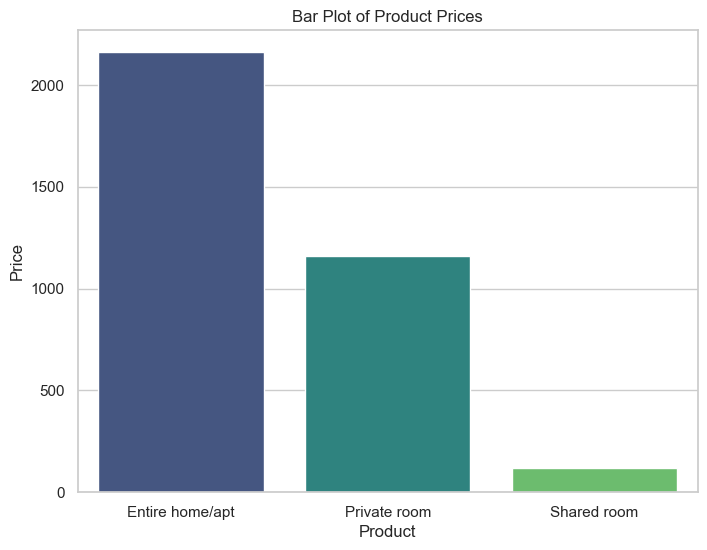

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a bar plot using Seaborn
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(8, 6))  # Set the figure size
# Convert Spark DataFrame to Pandas DataFrame
room_Type = room_Type.toPandas()
sns.barplot(x='room_type', y='count', data=room_Type, palette='viridis')

# Adding titles and labels
plt.title('Bar Plot of Product Prices')
plt.xlabel('Product')
plt.ylabel('Price')
plt.savefig('room_type.png')
plt.show()  # Display the plot






23/08/31 09:01:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/Users/badr/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  


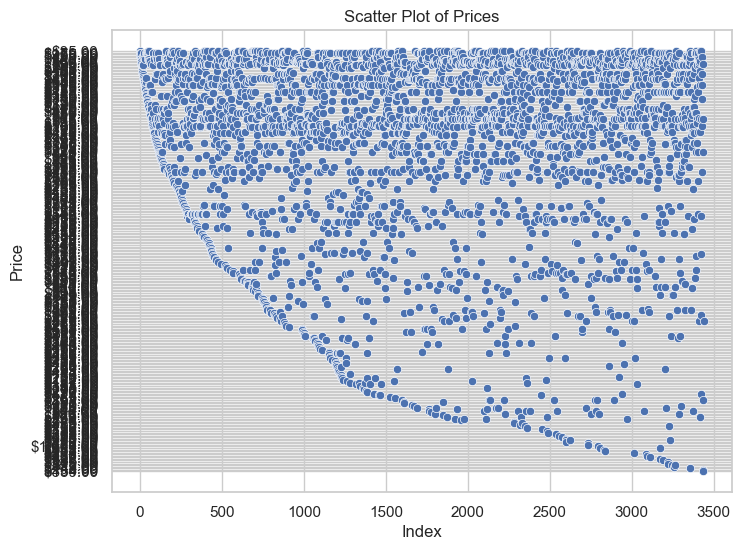

In [10]:
# figure out if there is outliers 
# price 
# Set the style
sns.set(style="whitegrid")
priceData = airBnBData_v1.toPandas()
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=range(priceData.shape[0]), y='price', data=priceData, palette='viridis')

# Adding titles and labels
plt.title('Scatter Plot of Prices')
plt.xlabel('Index')
plt.ylabel('Price')

# Show the plot
plt.show()

In [11]:
# price based on room

In [12]:


# Sample data for heatmap
airBnBData_v1 = airBnBData_v1.withColumn("price", translate(col("price"), "$,", "").cast("double"))
lat_long_price_values = airBnBData_v1.select(col("latitude"), col("longitude"), col("price")/600).collect()

lat_long_price_strings = [f"[{lat}, {long}, {price}]" for lat, long, price in lat_long_price_values]
# print(lat_long_price_strings)
v = ",\n".join(lat_long_price_strings)




In [4]:
import folium
from folium.plugins import HeatMap

sf_coordinates = (47.0000, -122.4194)
m = folium.Map(location=sf_coordinates, zoom_start=13)
# airBnBData_v1 = airBnBData_v1.orderBy(col("price").desc()).limit(15)
selectedMap = airBnBData_v1.select('latitude','longitude','price')
print(selectedMap.count())
converted_data = selectedMap.collect()
formatted_data = [[row.latitude, row.longitude, row.price/600] for row in converted_data]


# # Extract coordinates and prices
coordinates = [(lat, lon) for lat, lon, _ in formatted_data]
prices = [price for _, _, price in formatted_data]

# Create a heatmap layer with weights (prices)
heatmap_layer = HeatMap(coordinates, weights=prices, radius=15, max_val=max(prices))

# Add the heatmap layer to the map
heatmap_layer.add_to(m)

# Display the map
m

NameError: name 'airBnBData_v1' is not defined

In [14]:
# after doing some cleaning we can implemnt correlation to see which the most valuable column on our regression 
from pyspark.sql import Row
# col_names['bedrooms']
airBnBData_v1 = airBnBData_v1.withColumn("price", translate(col("price"), "$,", "").cast("double"))
correlation_list = []

for col_name in col_names:
    correlation = airBnBData_v1.stat.corr(col_name, "price")
    correlation_list.append(Row(Column=col_name, Correlation=correlation))

# Create a new DataFrame from the list
correlation_dataframe = spark.createDataFrame(correlation_list)




In [15]:
# Filter products where the correlation  is more than 50%
filtered_price_correlation = correlation_dataframe.filter(col("Correlation") > 0.50)

# Collect the filtered products into a Python list
filtered_price_list = []
filtered_price_list = [product["Column"] for product in filtered_price_correlation.collect()]


In [16]:



lat_long_price_values = airBnBData_v1.select(col("latitude"), col("longitude"), col("price")/600).collect()

lat_long_price_strings = [f"[{lat}, {long}, {price}]" for lat, long, price in lat_long_price_values]

v = ",\n".join(lat_long_price_strings)

# DO NOT worry about what this HTML code is doing! We took it from Stack Overflow :-)
# datadadd

In [17]:
from pyspark.sql.functions import count
roomsByNeighbourhood = airBnBData_v1.groupBy('neighbourhood').agg(count('bedrooms').alias('bedroomsCount')).orderBy(col('bedroomsCount').desc()).limit(10)
display(roomsByNeighbourhood.show())

+-----------------+-------------+
|    neighbourhood|bedroomsCount|
+-----------------+-------------+
|             null|          368|
|     Capitol Hill|          284|
|          Ballard|          199|
|            Minor|          180|
|       Queen Anne|          176|
|         Belltown|          161|
|          Fremont|          139|
|      Wallingford|          132|
|North Beacon Hill|           92|
|          Stevens|           91|
+-----------------+-------------+



None

In [18]:
from pyspark.sql.functions import sum
PricesByNeighbourhood = airBnBData_v1.groupBy('neighbourhood').agg(sum('price').alias('totalPrice')).orderBy(col('totalPrice').desc()).limit(10)
display(PricesByNeighbourhood.show())

+--------------------+----------+
|       neighbourhood|totalPrice|
+--------------------+----------+
|                null|   43253.0|
|        Capitol Hill|   38087.0|
|          Queen Anne|   30481.0|
|            Belltown|   28980.0|
|             Ballard|   25225.0|
|               Minor|   23686.0|
|             Fremont|   18426.0|
|         Wallingford|   17707.0|
|          First Hill|   12223.0|
|Central Business ...|   11750.0|
+--------------------+----------+



None

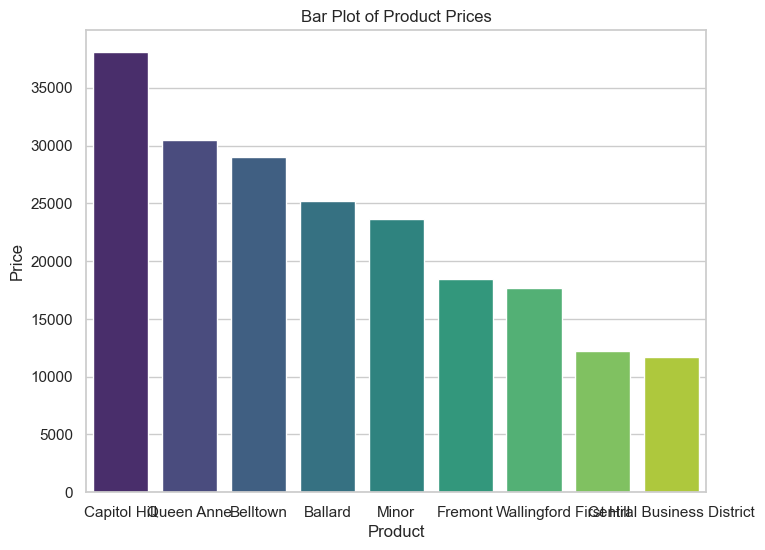

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a bar plot using Seaborn
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(8, 6))  # Set the figure size
# Convert Spark DataFrame to Pandas DataFrame
PricesByNeighbourhood = PricesByNeighbourhood.toPandas()
sns.barplot(x='neighbourhood', y='totalPrice', data=PricesByNeighbourhood, palette='viridis')

# Adding titles and labels
plt.title('Bar Plot of Product Prices')
plt.xlabel('Product')
plt.ylabel('Price')
plt.savefig('room_type.png')
plt.show()  # Display the plot

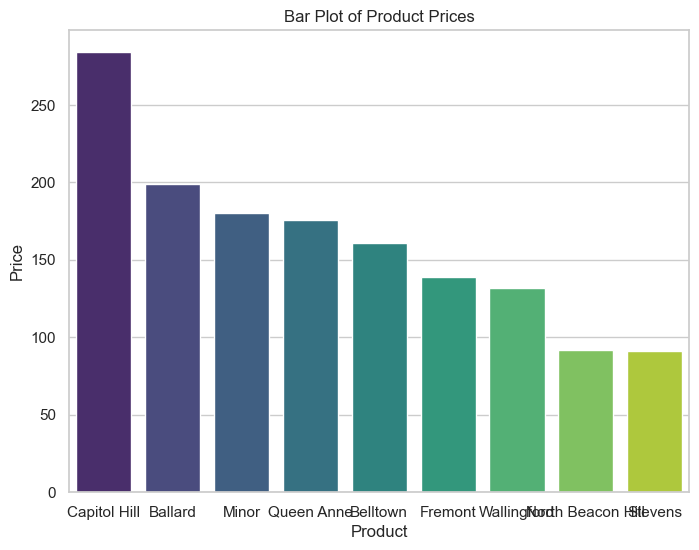

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a bar plot using Seaborn
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(8, 6))  # Set the figure size
# Convert Spark DataFrame to Pandas DataFrame
roomsByNeighbourhood = roomsByNeighbourhood.toPandas()
sns.barplot(x='neighbourhood', y='bedroomsCount', data=roomsByNeighbourhood, palette='viridis')

# Adding titles and labels
plt.title('Bar Plot of Product Prices')
plt.xlabel('Product')
plt.ylabel('Price')
plt.savefig('room_type.png')
plt.show()  # Display the plot

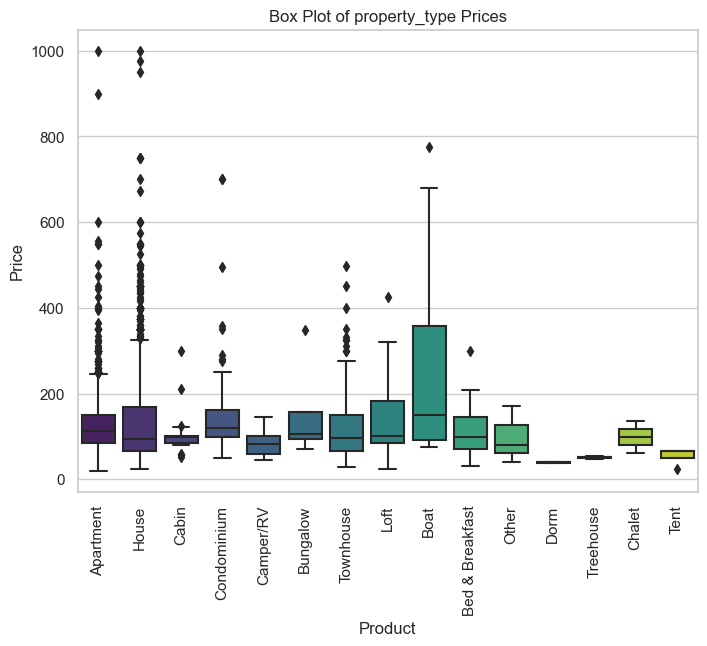

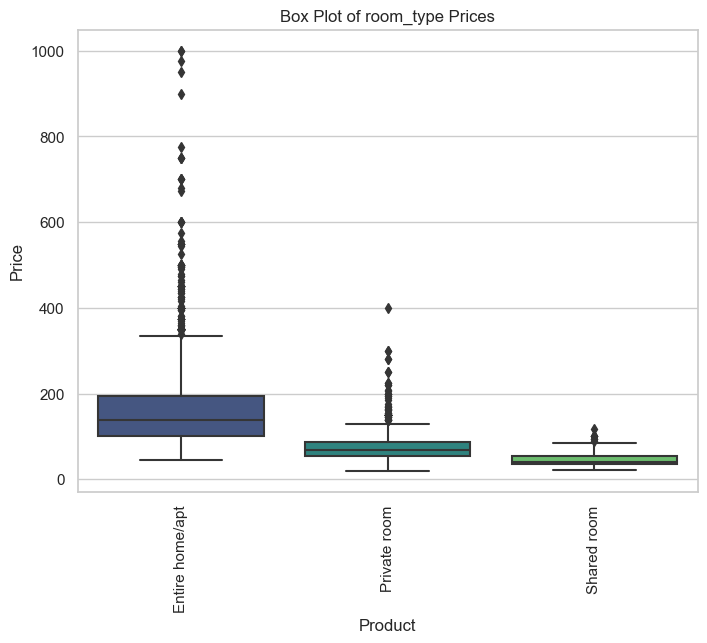

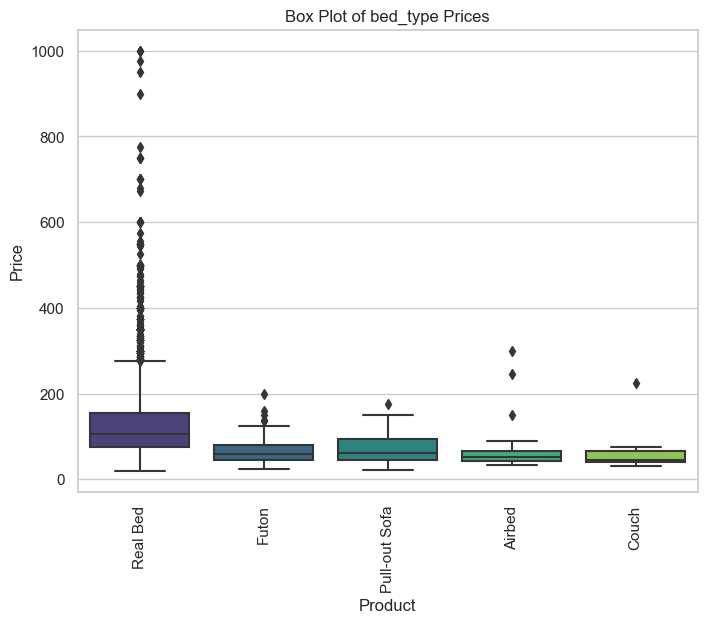

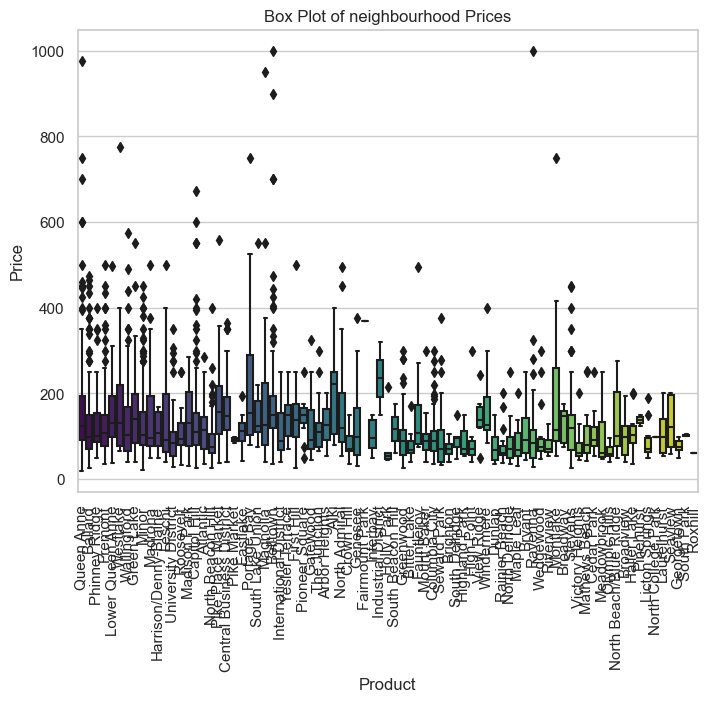

In [21]:
new_data = airBnBData_v1.toPandas()
def plot_graph(value):
    sns.set(style="whitegrid")

    # Create the box plot
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(x=value, y='price', data=new_data, palette='viridis')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    # Adding titles and labels
    plt.title(f'Box Plot of {value} Prices')
    plt.xlabel('Product')
    plt.ylabel('Price')

    # Show the plot
    plt.show()
plot_box_list = ['property_type', 'room_type', 'bed_type', 'neighbourhood']
for plo in plot_box_list:
    plot_graph(plo)



In [22]:
display(airBnBData_v1.select("price").describe().show())

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|              3438|
|   mean|130.64485165794068|
| stddev| 93.98820855335254|
|    min|              20.0|
|    max|            1000.0|
+-------+------------------+



None

In [23]:
# add the price to the list 
new_list = ['property_type', 'room_type', 'bed_type', 'neighbourhood','price']
pickedList = filtered_price_list + new_list

regressionDataFrame = airBnBData_v1.select(pickedList)

In [24]:
regressionDataFrame.orderBy(col('price').desc()).show()

+------------+---------+--------+----+-------------+---------------+--------+-----------------+------+
|accommodates|bathrooms|bedrooms|beds|property_type|      room_type|bed_type|    neighbourhood| price|
+------------+---------+--------+----+-------------+---------------+--------+-----------------+------+
|         4.0|      1.0|     2.0| 2.0|        House|Entire home/apt|Real Bed|          Ravenna|1000.0|
|         4.0|      1.0|     1.0| 1.0|    Apartment|Entire home/apt|Real Bed|         Belltown| 999.0|
|        11.0|      4.5|     5.0| 7.0|        House|Entire home/apt|Real Bed|       Queen Anne| 975.0|
|         6.0|      3.5|     3.0| 3.0|        House|Entire home/apt|Real Bed|         Magnolia| 950.0|
|        10.0|      2.0|     3.0| 4.0|    Apartment|Entire home/apt|Real Bed|         Belltown| 899.0|
|         8.0|      4.0|     4.0| 6.0|         Boat|Entire home/apt|Real Bed|         Westlake| 775.0|
|        10.0|      4.0|     6.0| 7.0|        House|Entire home/apt|Real 

In [25]:
from pyspark.ml.feature import Imputer

imputer = Imputer(strategy="median", inputCols=filtered_price_list, outputCols=filtered_price_list)

imputer_model = imputer.fit(regressionDataFrame)
imputed_df = imputer_model.transform(regressionDataFrame)
imputed_df.show(10)

+------------+---------+--------+----+-------------+---------------+--------+-------------+-----+
|accommodates|bathrooms|bedrooms|beds|property_type|      room_type|bed_type|neighbourhood|price|
+------------+---------+--------+----+-------------+---------------+--------+-------------+-----+
|         4.0|      1.0|     1.0| 1.0|    Apartment|Entire home/apt|Real Bed|   Queen Anne| 85.0|
|         4.0|      1.0|     1.0| 1.0|    Apartment|Entire home/apt|Real Bed|   Queen Anne|150.0|
|        11.0|      4.5|     5.0| 7.0|        House|Entire home/apt|Real Bed|   Queen Anne|975.0|
|         6.0|      2.0|     3.0| 3.0|        House|Entire home/apt|Real Bed|   Queen Anne|450.0|
|         2.0|      1.0|     1.0| 1.0|        House|   Private room|Real Bed|   Queen Anne|120.0|
|         2.0|      1.0|     1.0| 1.0|        House|   Private room|Real Bed|   Queen Anne| 80.0|
|         2.0|      1.0|     1.0| 1.0|        Cabin|   Private room|Real Bed|   Queen Anne| 60.0|
|         2.0|      

In [26]:
from delta import *

# path = '/Users/badr/Desktop/python/MLpySpark'
# imputed_df.write.format("delta").mode("overwrite").save('/Users/badr/Desktop/python/MLpySpark')

#split data into training and testing data 
train_df, test_df = imputed_df.randomSplit([.8, .2], seed=42)

In [27]:
from pyspark.ml import Pipeline
import mlflow
import mlflow.spark
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
with mlflow.start_run(run_name='LR-single-bedrooms', nested=True) as run :
    mlflow.set_tag("description", "This run uses Linear Regression with all features")
    vec_ass = VectorAssembler(inputCols=['bedrooms'], outputCol='features')
    lr = LinearRegression(featuresCol='features', labelCol='price')
    pipeline=Pipeline(stages=[vec_ass,lr])
    pipeline_model = pipeline.fit(train_df)
    
    # Log parameters
    mlflow.log_param("label", "price")
    mlflow.log_param("features", "bedrooms")

    # Log model
    mlflow.spark.log_model(pipeline_model, "model", input_example=train_df.limit(5).toPandas()) 

    # Evaluate predictions
    pred_df = pipeline_model.transform(test_df)
    display(pred_df.select('features','bedrooms','price','prediction').orderBy(col('bedrooms').desc()).show(20))
    regression_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="r2")
    regression_evaluator1 = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="rmse")
    rmse = regression_evaluator1.evaluate(pred_df)
    r2 = regression_evaluator.evaluate(pred_df)

    # Log metrics
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("rmse", rmse)

23/08/31 09:01:55 WARN Instrumentation: [52d1ea6b] regParam is zero, which might cause numerical instability and overfitting.
23/08/31 09:01:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/08/31 09:01:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+--------+--------+-----+------------------+
|features|bedrooms|price|        prediction|
+--------+--------+-----+------------------+
|   [6.0]|     6.0|490.0|483.93729264828966|
|   [6.0]|     6.0|673.0|483.93729264828966|
|   [5.0]|     5.0|350.0|406.00407363095445|
|   [5.0]|     5.0|495.0|406.00407363095445|
|   [5.0]|     5.0|350.0|406.00407363095445|
|   [5.0]|     5.0|325.0|406.00407363095445|
|   [5.0]|     5.0|465.0|406.00407363095445|
|   [5.0]|     5.0|399.0|406.00407363095445|
|   [4.0]|     4.0|250.0| 328.0708546136193|
|   [4.0]|     4.0|450.0| 328.0708546136193|
|   [4.0]|     4.0|195.0| 328.0708546136193|
|   [4.0]|     4.0|245.0| 328.0708546136193|
|   [4.0]|     4.0|499.0| 328.0708546136193|
|   [4.0]|     4.0|260.0| 328.0708546136193|
|   [4.0]|     4.0|375.0| 328.0708546136193|
|   [4.0]|     4.0|200.0| 328.0708546136193|
|   [4.0]|     4.0|270.0| 328.0708546136193|
|   [4.0]|     4.0|275.0| 328.0708546136193|
|   [4.0]|     4.0|525.0| 328.0708546136193|
|   [4.0]|

None

In [28]:
# lr_run = client.get_run('26d6c8d85db04476ae89c921d94115bc')  # Replace 'lr_run_id' with the actual run ID
# dt_run = client.get_run('5779db8370264cd4a1be49708a1dfd58')  # 

# lr_r2 = lr_run.data.metrics["rmse"]
# dt_r2 = dt_run.data.metrics["rmse"]

# print(lr_r2 , dt_r2)

In [29]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
train_df1, test_df1 = imputed_df.randomSplit([.8, .2], seed=42)
categorical_cols = [field for (field, dataType) in train_df1.dtypes if dataType == "string"]
print(categorical_cols)
index_output_cols = [x + "Index" for x in categorical_cols]
ohe_output_cols = [x + "OHE" for x in categorical_cols]

string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid="skip")
ohe_encoder = OneHotEncoder(inputCols=index_output_cols, outputCols=ohe_output_cols)
numeric_cols = [field for (field, dataType) in train_df1.dtypes if ((dataType == "double") & (field != "price"))]
assembler_inputs = ohe_output_cols + numeric_cols
vec_ass = VectorAssembler(inputCols = assembler_inputs, outputCol='features')


# df1 = string_indexer.fit(train_df1).transform(train_df1)

# pipeline = Pipeline(stages=[string_indexer,ohe_encoder,vec_ass
#                     ])
# df_transformed = pipeline.fit(test_df1).transform(test_df1)
# daer = ohe_encoder.fit(train_df1).transform(train_df1)



['property_type', 'room_type', 'bed_type', 'neighbourhood']


In [30]:

with mlflow.start_run(run_name='LR-Multiple-features') as run :
    
    
    vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
    vec_ass = VectorAssembler(inputCols = assembler_inputs, outputCol='features')
    lr = LinearRegression(featuresCol='features', labelCol='price')
    stages = [string_indexer, ohe_encoder, vec_assembler, lr]
    pipeline = Pipeline(stages=stages)

    pipeline_model = pipeline.fit(train_df1)
    
    # Log parameters
    mlflow.log_param("label", "price")
    mlflow.log_param("features", "bedrooms")

    # Log model
    mlflow.spark.log_model(pipeline_model, "model", input_example=train_df1.limit(5).toPandas()) 

    # Evaluate predictions
    pred_df = pipeline_model.transform(test_df1)
    display(pred_df.select('features','bedrooms','price','prediction').orderBy(col('bedrooms').desc()).show(20))
    regression_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="r2")
    regression_evaluator1 = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="rmse")
    rmse = regression_evaluator1.evaluate(pred_df)
    r2 = regression_evaluator.evaluate(pred_df)

    # Log metrics
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("rmse", rmse)

23/08/31 09:02:16 WARN Instrumentation: [2c073c1e] regParam is zero, which might cause numerical instability and overfitting.


+--------------------+--------+-----+------------------+
|            features|bedrooms|price|        prediction|
+--------------------+--------+-----+------------------+
|(103,[0,14,16,26,...|     6.0|490.0| 438.2298798419044|
|(103,[0,14,16,20,...|     6.0|673.0|459.97697100330134|
|(103,[0,14,16,29,...|     5.0|399.0| 392.3969304080592|
|(103,[0,14,16,80,...|     5.0|495.0| 394.0232040875916|
|(103,[0,14,16,45,...|     5.0|350.0|409.85261600980965|
|(103,[0,14,16,68,...|     5.0|325.0|430.56805394779536|
|(103,[0,14,16,21,...|     5.0|465.0| 404.5926699345693|
|(103,[0,14,16,30,...|     5.0|350.0|397.04500702476827|
|(103,[0,14,16,46,...|     4.0|250.0| 277.2630407224522|
|(103,[0,14,16,42,...|     4.0|200.0|274.58138969288797|
|(103,[0,14,16,90,...|     4.0|244.0|264.59541154323045|
|(103,[0,14,16,23,...|     4.0|450.0|320.63618422750307|
|(103,[0,14,16,45,...|     4.0|195.0| 336.8140016290256|
|(103,[0,14,16,23,...|     4.0|499.0|353.22114226732526|
|(103,[0,14,16,68,...|     4.0|

None

In [31]:
from pyspark.ml.feature import RFormula

with mlflow.start_run(run_name="LR-All-Features") as run:
    # Create pipeline
    r_formula = RFormula(formula="price ~ .", featuresCol="features", labelCol="price", handleInvalid="skip")
    lr = LinearRegression(labelCol="price", featuresCol="features")
    pipeline = Pipeline(stages=[r_formula, lr])
    pipeline_model = pipeline.fit(train_df)

    # Log pipeline
    mlflow.spark.log_model(pipeline_model, "model", input_example=train_df.limit(5).toPandas())

    # Log parameter
    mlflow.log_param("label", "price")
    mlflow.log_param("features", "all_features")

    # Create predictions and metrics
    pred_df = pipeline_model.transform(test_df)
    display(pred_df.select('features','bedrooms','price','prediction').orderBy(col('bedrooms').desc()).show(20))
    regression_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")
    rmse = regression_evaluator.setMetricName("rmse").evaluate(pred_df)
    r2 = regression_evaluator.setMetricName("r2").evaluate(pred_df)

    # Log both metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)

23/08/31 09:02:35 WARN Instrumentation: [9d8c7cd9] regParam is zero, which might cause numerical instability and overfitting.


+--------------------+--------+-----+------------------+
|            features|bedrooms|price|        prediction|
+--------------------+--------+-----+------------------+
|(103,[0,1,2,3,4,1...|     6.0|490.0|438.22987984190394|
|(103,[0,1,2,3,4,1...|     6.0|673.0|459.97697100330134|
|(103,[0,1,2,3,4,1...|     5.0|399.0| 392.3969304080594|
|(103,[0,1,2,3,4,1...|     5.0|495.0|  394.023204087591|
|(103,[0,1,2,3,4,1...|     5.0|350.0| 409.8526160098093|
|(103,[0,1,2,3,4,1...|     5.0|325.0|430.56805394779525|
|(103,[0,1,2,3,4,1...|     5.0|465.0|404.59266993456924|
|(103,[0,1,2,3,4,1...|     5.0|350.0| 397.0450070247682|
|(103,[0,1,2,3,4,1...|     4.0|250.0|277.26304072245193|
|(103,[0,1,2,3,4,1...|     4.0|200.0| 274.5813896928875|
|(103,[0,1,2,3,4,1...|     4.0|244.0|   264.59541154323|
|(103,[0,1,2,3,4,1...|     4.0|450.0| 320.6361842275028|
|(103,[0,1,2,3,4,1...|     4.0|195.0|336.81400162902537|
|(103,[0,1,2,3,4,1...|     4.0|499.0| 353.2211422673251|
|(103,[0,1,2,3,4,1...|     4.0|

None

In [32]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.search_experiments()

experiment_id = run.info.experiment_id
# print(experiment_id)
runs_df = mlflow.search_runs(experiment_id)
# print(runs_df)
print(runs_df.artifact_uri[0])

artifact_uri = run.info.artifact_uri
model_path = artifact_uri + "/model"
loaded_model = mlflow.spark.load_model(model_path)
pred_df = loaded_model.transform(test_df)
display(pred_df.select('features','bedrooms','price','prediction').orderBy(col('bedrooms').desc()).show(20))

2023/08/31 09:02:59 INFO mlflow.spark: File 'file:///Users/badr/Desktop/python/MLpySpark/mlruns/0/6cd8972eacf0417c9e45f5cf48dc5dd3/artifacts/model/sparkml' is already on DFS, copy is not necessary.


file:///Users/badr/Desktop/python/MLpySpark/mlruns/0/6cd8972eacf0417c9e45f5cf48dc5dd3/artifacts
+--------------------+--------+-----+------------------+
|            features|bedrooms|price|        prediction|
+--------------------+--------+-----+------------------+
|(103,[0,1,2,3,4,1...|     6.0|490.0|438.22987984190394|
|(103,[0,1,2,3,4,1...|     6.0|673.0|459.97697100330134|
|(103,[0,1,2,3,4,1...|     5.0|399.0| 392.3969304080594|
|(103,[0,1,2,3,4,1...|     5.0|495.0|  394.023204087591|
|(103,[0,1,2,3,4,1...|     5.0|350.0| 409.8526160098093|
|(103,[0,1,2,3,4,1...|     5.0|325.0|430.56805394779525|
|(103,[0,1,2,3,4,1...|     5.0|465.0|404.59266993456924|
|(103,[0,1,2,3,4,1...|     5.0|350.0| 397.0450070247682|
|(103,[0,1,2,3,4,1...|     4.0|250.0|277.26304072245193|
|(103,[0,1,2,3,4,1...|     4.0|200.0| 274.5813896928875|
|(103,[0,1,2,3,4,1...|     4.0|244.0|   264.59541154323|
|(103,[0,1,2,3,4,1...|     4.0|450.0| 320.6361842275028|
|(103,[0,1,2,3,4,1...|     4.0|195.0|336.81400162

None

In [33]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.search_experiments()

best_model = None
all_runs = client.search_runs(experiment_ids=['0'])
best_r2 = -float("inf")  # Initialize with negative infinity
print(run.info.run_id)
# Iterate through all runs
for run_info in all_runs:
    run_id = run.info.run_id
    
    run = client.get_run(run_id)
    # metrics = client.get_run(run_id).data.metrics
    
    # Check if 'r2' metric is available for this run
    if 'r2' in run.data.metrics:
        r2 = run.data.metrics['r2']
        
        # Compare R-squared values
        if r2 > best_r2:
            best_r2 = r2
            best_model = run.info.artifact_uri + "/model"
            
# Load the best model
if best_model:
    loaded_model1 = mlflow.spark.load_model(best_model)
    print("Best Model:", loaded_model)
else:
    print("No model with R-squared metric found.")

2023/08/31 09:03:02 INFO mlflow.spark: File 'file:///Users/badr/Desktop/python/MLpySpark/mlruns/0/6cd8972eacf0417c9e45f5cf48dc5dd3/artifacts/model/sparkml' is already on DFS, copy is not necessary.


6cd8972eacf0417c9e45f5cf48dc5dd3
Best Model: PipelineModel_e7214dc616fd


In [34]:
pred_df = loaded_model1.transform(test_df)
display(pred_df.select('features','bedrooms','price','prediction').orderBy(col('bedrooms').desc()).show(20))

+--------------------+--------+-----+------------------+
|            features|bedrooms|price|        prediction|
+--------------------+--------+-----+------------------+
|(103,[0,1,2,3,4,1...|     6.0|490.0|438.22987984190394|
|(103,[0,1,2,3,4,1...|     6.0|673.0|459.97697100330134|
|(103,[0,1,2,3,4,1...|     5.0|399.0| 392.3969304080594|
|(103,[0,1,2,3,4,1...|     5.0|495.0|  394.023204087591|
|(103,[0,1,2,3,4,1...|     5.0|350.0| 409.8526160098093|
|(103,[0,1,2,3,4,1...|     5.0|325.0|430.56805394779525|
|(103,[0,1,2,3,4,1...|     5.0|465.0|404.59266993456924|
|(103,[0,1,2,3,4,1...|     5.0|350.0| 397.0450070247682|
|(103,[0,1,2,3,4,1...|     4.0|250.0|277.26304072245193|
|(103,[0,1,2,3,4,1...|     4.0|200.0| 274.5813896928875|
|(103,[0,1,2,3,4,1...|     4.0|244.0|   264.59541154323|
|(103,[0,1,2,3,4,1...|     4.0|450.0| 320.6361842275028|
|(103,[0,1,2,3,4,1...|     4.0|195.0|336.81400162902537|
|(103,[0,1,2,3,4,1...|     4.0|499.0| 353.2211422673251|
|(103,[0,1,2,3,4,1...|     4.0|

None

In [35]:
# create our random forest pipeline and regression evaluator.
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
train_df, val_df, test_df = imputed_df.randomSplit([.6, .2, .2], seed=42)
categorical_cols = [field for (field, dataType) in train_df.dtypes if dataType == "string"]
index_output_cols = [x + "Index" for x in categorical_cols]

string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid="skip")

numeric_cols = [field for (field, dataType) in train_df.dtypes if ((dataType == "double") & (field != "price"))]
assembler_inputs = index_output_cols + numeric_cols
vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
rf = RandomForestRegressor(labelCol='price', maxBins=80, seed=42)
print(string_indexer,vec_ass )
pipeline = Pipeline(stages=[string_indexer, vec_assembler, rf])
regression_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price")

StringIndexer_e735b1be259f VectorAssembler_e4f37797442d


In [36]:
def objective_function(params):    
    # set the hyperparameters that we want to tune
    max_depth = params["max_depth"]
    num_trees = params["num_trees"]

    with mlflow.start_run():
        estimator = pipeline.copy({rf.maxDepth: max_depth, rf.numTrees: num_trees})
        model = estimator.fit(train_df)

        preds = model.transform(val_df)
        rmse = regression_evaluator.evaluate(preds)
        mlflow.log_metric("rmse", rmse)

    return rmse

In [37]:
from hyperopt import hp

search_space = {
    "max_depth": hp.quniform("max_depth", 2, 5, 1),
    "num_trees": hp.quniform("num_trees", 10, 100, 1)
}

In [38]:
from hyperopt import fmin, tpe, Trials
import numpy as np
import mlflow
import mlflow.spark
mlflow.pyspark.ml.autolog(log_models=False)
num_evals = 4
trials = Trials()
best_hyperparam = fmin(fn=objective_function, 
                       space=search_space,
                       algo=tpe.suggest, 
                       max_evals=num_evals,
                       trials=trials,
                       rstate=np.random.default_rng(42))

# Retrain model on train & validation dataset and evaluate on test dataset
with mlflow.start_run():
    best_max_depth = best_hyperparam["max_depth"]
    best_num_trees = best_hyperparam["num_trees"]
    estimator = pipeline.copy({rf.maxDepth: best_max_depth, rf.numTrees: best_num_trees})
    combined_df = train_df.union(val_df) # Combine train & validation together

    pipeline_model = estimator.fit(combined_df)
    pred_df = pipeline_model.transform(test_df)
    rmse = regression_evaluator.evaluate(pred_df)
    r2 = regression_evaluator.setMetricName("r2").evaluate(pred_df)

    # Log param and metrics for the final model
    mlflow.log_param("maxDepth", best_max_depth)
    mlflow.log_param("numTrees", best_num_trees)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.spark.log_model(pipeline_model, "model")


2023/08/31 09:03:05 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pyspark.ml. If you encounter errors during autologging, try upgrading / downgrading pyspark.ml to a supported version, or try upgrading MLflow.


100%|██████████| 4/4 [00:06<00:00,  1.63s/trial, best loss: 57.395240879982474]


In [39]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.search_experiments()
all_runs = client.search_runs(experiment_ids=['0'])
print(all_runs)

[<Run: data=<RunData: metrics={'r2': 0.44455733817095455,
 'r2_test_df': 0.44455733817095455,
 'rmse': 86.66964343564928,
 'rmse_test_df': 86.66964343564928}, params={'RandomForestRegressor.bootstrap': 'True',
 'RandomForestRegressor.cacheNodeIds': 'False',
 'RandomForestRegressor.checkpointInterval': '10',
 'RandomForestRegressor.featureSubsetStrategy': 'auto',
 'RandomForestRegressor.featuresCol': 'features',
 'RandomForestRegressor.impurity': 'variance',
 'RandomForestRegressor.labelCol': 'price',
 'RandomForestRegressor.leafCol': '',
 'RandomForestRegressor.maxBins': '80',
 'RandomForestRegressor.maxDepth': '4',
 'RandomForestRegressor.maxMemoryInMB': '256',
 'RandomForestRegressor.minInfoGain': '0.0',
 'RandomForestRegressor.minInstancesPerNode': '1',
 'RandomForestRegressor.minWeightFractionPerNode': '0.0',
 'RandomForestRegressor.numTrees': '83',
 'RandomForestRegressor.predictionCol': 'prediction',
 'RandomForestRegressor.seed': '42',
 'RandomForestRegressor.subsamplingRate': '

In [40]:
experiment_id = run.info.experiment_id
runs = client.search_runs(experiment_id, order_by=["attributes.start_time desc"], max_results=1)
runs[0].data.metrics

{'rmse_test_df': 86.66964343564928,
 'r2_test_df': 0.44455733817095455,
 'r2': 0.44455733817095455,
 'rmse': 86.66964343564928}

In [41]:
import mlflow
import pandas as pd
from mlflow.entities import ViewType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Start a Spark session


# List of columns for the DataFrame
columns = ["run_description", "run id","Model ID", "Model URL", "R2", "RMSE", "status"]

# Create an empty DataFrame
results_df = pd.DataFrame(columns=columns)

# Get the list of runs from MLflow (you might need to adjust the filter conditions)
runs = mlflow.search_runs(filter_string="", run_view_type=ViewType.ALL)

# Iterate over the runs
for _, run in runs.iterrows():
    # run_description = run["description"]
    run_id = run["run_id"]
    model_id = run["artifact_uri"].split("/")[-1]
    model_url = mlflow.get_artifact_uri(run["run_id"])
    r2 = run["metrics.r2"]
    rmse = run["metrics.rmse"]
    model_status = "Completed" if run["status"] == "FINISHED" else "Not Completed"
    
    # Append the information to the DataFrame
    results_df = results_df.append({
        # "Run Name": run_description,
        "Run ID": run_id,
        "Model ID": model_id,
        "Model URL": model_url,
        "R2": r2,
        "RMSE": rmse,
        "Model Status": model_status
        
    }, ignore_index=True)

# Display the resulting DataFrame
print(results_df)

    run_description  run id   Model ID  \
0               NaN     NaN  artifacts   
1               NaN     NaN  artifacts   
2               NaN     NaN  artifacts   
3               NaN     NaN  artifacts   
4               NaN     NaN  artifacts   
..              ...     ...        ...   
62              NaN     NaN  artifacts   
63              NaN     NaN  artifacts   
64              NaN     NaN  artifacts   
65              NaN     NaN  artifacts   
66              NaN     NaN  artifacts   

                                            Model URL        R2       RMSE  \
0   file:///Users/badr/Desktop/python/MLpySpark/ml...  0.444557  86.669643   
1   file:///Users/badr/Desktop/python/MLpySpark/ml...       NaN  60.767469   
2   file:///Users/badr/Desktop/python/MLpySpark/ml...       NaN  64.728791   
3   file:///Users/badr/Desktop/python/MLpySpark/ml...       NaN  58.565784   
4   file:///Users/badr/Desktop/python/MLpySpark/ml...       NaN  57.395241   
..                         

In [42]:
# for idx, stage in enumerate(loaded_model.stages):
#     print(f"Stage {idx + 1}: {stage.__class__.__name__}")
#     print("Parameters:")
#     for param_name, param_value in stage.extractParamMap().items():
#         print(f"  {param_name}: {param_value}")


In [43]:
all_runs = client.search_runs(experiment_ids=['0'])
# print(all_runs)

# Iterate through all runs and delete artifacts and run information
# for run in all_runs:
#     run_id = run.info.run_id
#     client.delete_run(run_id)